## References

Quote Mid Price = Spot Price + Basis + Skew  
https://blog.bitmex.com/how-to-market-make-bitcoin-derivatives-lesson-2/  
https://www.bitmex.com/app/fairPriceMarking  
https://www.bitmex.com/app/perpetualContractsGuide  
https://github.com/BitMEX/sample-market-maker  

BuyPrice = Mid-Market + A x Forecast – B x MCR – Current half-spread  
SellPrice = Mid-Market + A x Forecast – B x MCR + Current half-spread  
**https://ieor.columbia.edu/files/seasdepts/industrial-engineering-operations-research/pdf-files/Borden_D_FESeminar_Sp10.pdf ****  

https://www.reddit.com/r/algotrading/comments/6q8dp6/market_making_theory_and_application_readings/

**https://www.reddit.com/r/algotrading/comments/k4x9ft/we_all_know_moving_average_crossovers_are_crap/gec6xji?utm_source=share&utm_medium=web2x&context=3 !!!**

## Implementation
https://github.com/nkaz001/sample-market-maker

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numba import njit

In [2]:
# last_price = pd.read_csv("last_price.csv", index_col='timestamp', converters={'timestamp': pd.to_datetime})
# ohlc = last_price.resample('5s', closed='right', label='right').ohlc().ffill()

In [3]:
# mid price = (best bid + best ask) / 2
# buy = sum of bid volume up to (1 - x%) * mid price
# sell = sum of ask volume up to (1 + x%) * mid price
# excessive_buy = buy - sell

# excessive_buy = pd.read_pickle('excessive_buy')
# excessive_buy = excessive_buy.resample('5s', closed='right', label='right').last()

In [4]:
# df = ohlc.merge(excessive_buy, left_on='timestamp', right_on='timestamp', how='outer')

In [5]:
df = pd.read_pickle('data')

In [6]:
df

,open,high,low,close,0.5%,1%,2.5%,5%,7.5%,10%,15%,20%,25%
timestamp,,,,,,,,,,,,,
2019-07-01 00:00:00,10761.0,10761.0,10760.5,10761.0,-1645839.0,-1838275.0,45878691.0,98461633.0,106882242.0,115700696.0,150299371.0,160180977.0,165893323.0
2019-07-01 00:00:05,10760.5,10761.0,10760.5,10761.0,-1418922.0,-1009210.0,48105966.0,100560816.0,108982890.0,117801272.0,152400583.0,162303702.0,167981836.0
2019-07-01 00:00:10,10760.5,10761.0,10760.5,10760.5,-1422381.0,-1012110.0,48103066.0,100557878.0,108979952.0,117798334.0,152397645.0,162300764.0,167978898.0
2019-07-01 00:00:15,10761.0,10764.5,10760.5,10760.5,-846259.0,2360614.0,49330033.0,101892495.0,110244274.0,119045690.0,153570364.0,163520577.0,169225317.0
2019-07-01 00:00:20,10761.0,10772.0,10760.5,10770.5,634740.0,671124.0,43232662.0,101120846.0,108953943.0,118607510.0,152460455.0,163072175.0,169365193.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07 23:59:40,39486.5,39486.5,39482.0,39482.0,-4732072.0,-5491978.0,-9003268.0,2376836.0,14580848.0,32936506.0,68611651.0,92225843.0,109759067.0
2021-01-07 23:59:45,39481.5,39487.5,39480.5,39487.0,-3696090.0,-3933238.0,-7456244.0,397736.0,12485792.0,30946208.0,66640355.0,90245747.0,107287971.0
2021-01-07 23:59:50,39481.5,39487.5,39480.5,39487.0,-5195481.0,-5312378.0,-8835384.0,-981404.0,11106652.0,29568068.0,65262165.0,88867557.0,105909781.0


In [7]:
@njit
def predict_njit(start_equity, A, B, half_spread, max_position, X):
    tick_size = 0.5
    running_qty = 0
    static_equity = start_equity
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 100
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    excessive_buy = 7
    for row in X:
        if new_bid > row[low]:
            running_qty += order_qty
            static_equity += order_qty / new_bid
            fee += order_qty / new_bid * -0.00025    
        if new_ask < row[high]:
            running_qty -= order_qty
            static_equity -= order_qty / new_ask
            fee += order_qty / new_ask * -0.00025    
        equity.append(static_equity - running_qty / row[close] - fee)
        running_qty_.append(running_qty)
        skew = B * running_qty / max_position * -1
        quote_mid_price = row[close] + A * row[excessive_buy] / 100000000 + skew
        new_bid = np.minimum(np.round(quote_mid_price * (1 - half_spread) / tick_size) * tick_size, row[close] - tick_size)
        new_ask = np.maximum(np.round(quote_mid_price * (1 + half_spread) / tick_size) * tick_size, row[close] + tick_size)
        if running_qty > max_position:
            new_bid = np.nan
        if running_qty < -max_position:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, equity=None, max_position=None, A=None, B=None, half_spread=None):
        self.equity = equity
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        
    def set_params(self, A, B, half_spread):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        return self
        
    def get_params(self, deep=True):
        return { 'equity': self.equity, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
#         #orders = []
#         tick_size = 0.5
#         running_qty = 0
#         static_equity = self.equity
#         fee = 0
#         equity = []
#         order_qty = 100
#         new_bid = np.nan
#         new_ask = np.nan
#         for _, row in X.iterrows():
#             #for price, qty in orders:
#             #    if qty > 0 and price >= row['low']:
#             #        running_qty += qty
#             #        static_equity -= qty / price
#             #        fee += qty / price * -0.00025    
#             #    if qty < 0 and price <= row['high']:
#             #        running_qty -= qty
#             #        static_equity += qty / price
#             #        fee += qty / price * -0.00025    
#             if new_bid > row['low']:
#                 running_qty += order_qty
#                 static_equity += order_qty / new_bid
#                 fee += order_qty / new_bid * -0.00025    
#             if new_ask < row['high']:
#                 running_qty -= order_qty
#                 static_equity -= order_qty / new_ask
#                 fee += order_qty / new_ask * -0.00025    
#             equity.append(static_equity - running_qty / row['close'] - fee)
#             skew = self.B * running_qty / self.max_position * -1
#             quote_mid_price = row['close'] + self.A * row['fairBasis'] + skew
#             new_bid = np.minimum(np.round(quote_mid_price * (1 - self.half_spread) / tick_size) * tick_size, row['close'] - tick_size)
#             new_ask = np.maximum(np.round(quote_mid_price * (1 + self.half_spread) / tick_size) * tick_size, row['close'] + tick_size)
#             #if running_qty < self.max_position:
#             #    orders.append((new_bid, 100))
#             #if running_qty > -self.max_position:
#             #    orders.append((new_ask, -100))
#             if running_qty > self.max_position:
#                 new_bid = np.nan
#             if running_qty < -self.max_position:
#                 new_ask = np.nan
        equity, running_qty = predict_njit(self.equity, self.A, self.B, self.half_spread, self.max_position, X)
        return equity, running_qty
    
    def score(self, X):
        equity, _ = self.predict(X)
        returns = pd.Series(equity).pct_change().fillna(0)
#         bm_returns = pd.Series(X[:, 3]).pct_change().fillna(0)
#         returns_ = returns - bm_returns
        return np.divide(returns.mean(), returns.std())

In [8]:
train = df[df.index < '2020-1-1']
test = df[df.index >= '2020-1-1']

In [9]:
#parameters = { 'A': np.linspace(0.01, 1, 100), 'B': np.linspace(0.01, 1, 100), 'half_spread': np.linspace(0.001, 0.01, 10) }
#search = GridSearchCV(Backtest(10000, 10000), parameters)
#search.fit(df)

param_dist = { 'A': stats.uniform(50, 500), 'B': stats.uniform(1, 50), 'half_spread': stats.uniform(0, 0.001) }
search = RandomizedSearchCV(Backtest(1, 10000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=8)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   45.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  4.0min finished


RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 3179517, 3179518, 3179519]),
                        array([      0,       1,       2, ..., 3179517, 3179518, 3179519]))],
                   estimator=<__main__.Backtest object at 0x7f54a5c04250>,
                   n_iter=1000, n_jobs=8,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f54a5c042d0>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f54a5c046d0>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f54a5c04610>},
                   verbose=1)

In [10]:
search.best_params_

{'A': 53.69024193790823,
 'B': 44.26080387202236,
 'half_spread': 0.00091530679386619}

In [11]:
search.best_estimator_.score(train.values)

0.001928838331132949

In [12]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

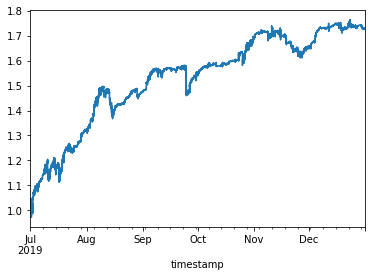

In [13]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

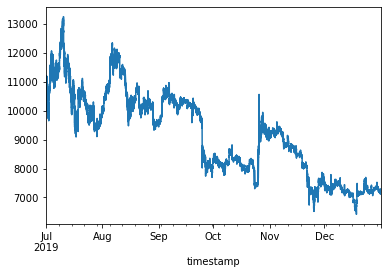

In [14]:
train["close"].plot()

<AxesSubplot:xlabel='timestamp'>

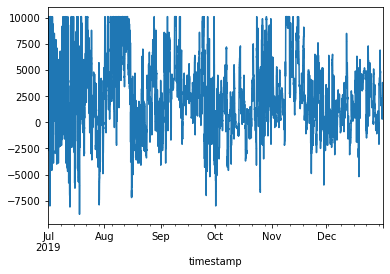

In [15]:
running_qty.plot()

Start date            2019-07-01
End date              2019-12-31
Time period (days)           183
Sharpe Ratio            3.760950
CAGR                    1.979518
Max Daily Drawdown      0.067246
dtype: object


<AxesSubplot:>

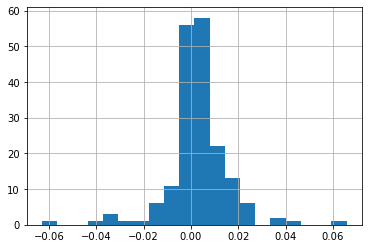

In [16]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = train['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

In [17]:
equity, running_qty = search.best_estimator_.predict(test.values)
equity = pd.Series(equity, index=test.index)
running_qty = pd.Series(running_qty, index=test.index)

<AxesSubplot:xlabel='timestamp'>

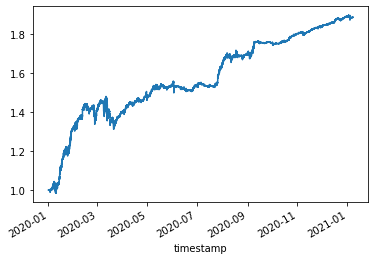

In [18]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

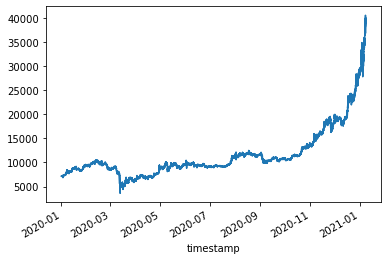

In [19]:
test["close"].plot()

<AxesSubplot:xlabel='timestamp'>

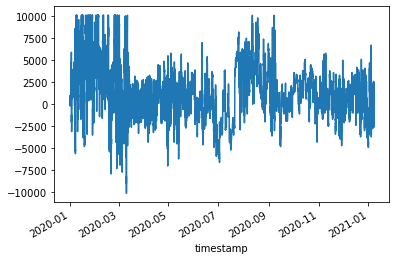

In [20]:
running_qty.plot()

Start date            2020-01-01
End date              2021-01-08
Time period (days)           373
Sharpe Ratio            3.094482
CAGR                    0.860911
Max Daily Drawdown      0.102859
dtype: object


<AxesSubplot:>

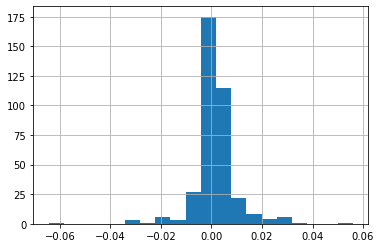

In [21]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = test['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

Start date            2019-07-01
End date              2021-01-08
Time period (days)           557
Sharpe Ratio            3.182883
CAGR                    0.878106
Max Daily Drawdown      0.068740
dtype: object


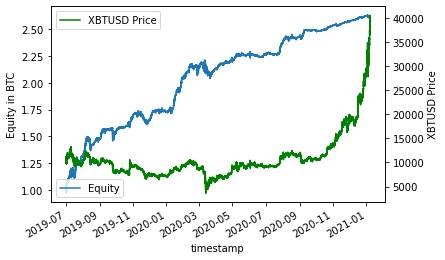

In [22]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().pct_change() 
bm_returns = test['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure()
ax1 = equity.plot()
ax2 = df['close'].plot(secondary_y=True, style='g')
ax2.set_ylabel('XBTUSD Price')
ax1.set_ylabel('Equity in BTC')
ax1.legend(['Equity'], loc=3)
ax2.legend(['XBTUSD Price'])